### Test model for breakout

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import gym

import torch
import torch.nn as nn
import torch.nn.init as nn_init
import torch.optim as optim
from torch.autograd import Variable

import breakout
from imp import reload
reload(breakout)

import copy
import datetime

import json
import pickle

import sys
import multiprocessing as mp

from collections import defaultdict

In [2]:
class dotdict(defaultdict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = defaultdict.get
    __setattr__ = defaultdict.__setitem__
    __delattr__ = defaultdict.__delitem__

In [3]:
#Cuda support

CUDA = True
def ToTensor(arr):
    if CUDA:
        return torch.Tensor(arr).cuda()
    else:
        return torch.Tensor(arr)

In [4]:
#Служебные слои
class RavelLevel(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

In [5]:
def CreateNewNetwork(*layers):
    network = nn.Sequential(*layers)
    if CUDA:
        return network.cuda()
    else:
        return network
    
def GetNetworkCreatror(*layers):
    def creator():
        return CreateNewNetwork(*layers)
    return creator

In [8]:
#Загрузка модели
#ES
ES_layers = [nn.Conv2d(3, 16, kernel_size=8, stride=4), nn.ReLU(),
             nn.Conv2d(16, 32, kernel_size=4, stride=2), nn.ReLU(),
             RavelLevel(),
             nn.Linear(13824, 160), nn.ReLU(),
             nn.Linear(160, 4, bias=False), nn.Softmax(dim=1)]

model_es = CreateNewNetwork(*ES_layers)
with open('models/model_breakout-determ_es_1000.dat', 'rb') as file:
    state_dict = pickle.load(file)
    model_es.load_state_dict(state_dict)

KeyboardInterrupt: 

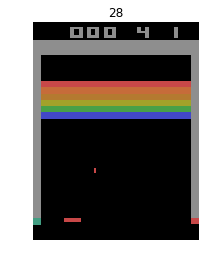

In [9]:
#Example game
reload(breakout)
game = breakout.Breakout(game='BreakoutDeterministic-v4', cuda=CUDA)
for test_seed in range(0, 20):
    game.GetSummaryScore(model_es, seed=test_seed, max_screens=600, visualizate=True)

In [51]:
#QL - вспомогательные функции и классы
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
from IPython import display
from itertools import count

resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=8, stride=4)
        nn_init.normal(self.conv1.weight.data, std=0.1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        nn_init.normal(self.conv2.weight.data, std=0.1)
        self.lin1 = nn.Linear(480, 160)
        nn_init.normal(self.lin1.weight.data, std=0.1)
        self.head = nn.Linear(160, 4, bias=False)
        nn_init.normal(self.head.weight.data, std=0.1)
        self.softmax = nn.Softmax(1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.lin1(x.view(x.size(0), -1)))
        return self.softmax(self.head(x))

def to_grayscale(img):
    return np.mean(img, axis=2).astype(np.uint8)[:,:,None]

def get_screen(env):
    screen = env.render(mode='rgb_array')
    # transpose into torch order (CHW)
    screen = to_grayscale(screen).transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    screen = resize(screen)
    return screen[0]

def image_to_tensor(arr):
    result = torch.Tensor(arr).cuda()
    result = result.view(1, 1, result.shape[0], result.shape[1])
    return Variable(result)

def select_action(model, state):
    res = model(state)
    return res.max(1)[1].view(1, 1)

def show_env(env, title):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title(title)
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [78]:
#Загрузка модели 
model_dqn = DQN().cuda()
with open('models/model_breakout-determ_ql_27361.dat', 'rb') as file:
    state_dict = pickle.load(file)
    model_dqn.load_state_dict(state_dict)

KeyboardInterrupt: 

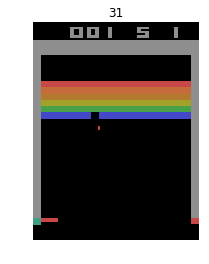

In [96]:
#Example game
reload(breakout)
game_env = gym.make('BreakoutDeterministic-v4')
for test_seed in range(0, 20):
    game_env.seed(test_seed)
    game_env.reset()
    
    prev_state = image_to_tensor(get_screen(game_env))
    new_state = prev_state
    done = False
    game_env.step(1)
    for t in count():
        state = new_state - prev_state
        action = select_action(model_dqn, state)
        _, _, done, _ = game_env.step(int(action.data.cpu().numpy().ravel()[0]))
        prev_state = new_state
        new_state = image_to_tensor(get_screen(game_env))
        
        if (np.all(prev_state.data.cpu().numpy() == new_state.data.cpu().numpy())):
            game_env.step(1)
            
        if done:
            break
        
        show_env(game_env, str(t))

In [6]:
#Загрузка модели
#GA
GA_layers = [nn.Conv2d(3, 16, kernel_size=8, stride=4), nn.ReLU(),
             nn.Conv2d(16, 32, kernel_size=4, stride=2), nn.ReLU(),
             RavelLevel(),
             nn.Linear(13824, 160), nn.ReLU(),
             nn.Linear(160, 4, bias=False), nn.Softmax(dim=1)]

model_ga = CreateNewNetwork(*GA_layers)
with open('models/model_breakout-determ_ga_900.dat.0', 'rb') as file:
    state_dict = pickle.load(file)
    model_ga.load_state_dict(state_dict)

KeyboardInterrupt: 

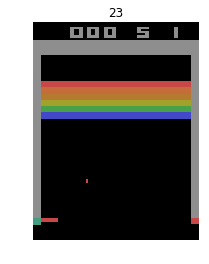

In [7]:
#Example game
reload(breakout)
game = breakout.Breakout(game='BreakoutDeterministic-v4', cuda=CUDA)
for test_seed in range(0, 10):
    game.GetSummaryScore(model_ga, seed=test_seed, max_screens=1000, visualizate=True)